# Internet Service Plans - Statistical Analysis 

The objective of this project is to determine which of the two telecommunication plans, surf and ultimate, are more profitable and need a reallocation of budgetting resources or plan details. After performing data preprocessing, some statistical analysis will be performed to analyze client behavior. 

In [1]:
import pandas as pd 
import numpy as np 
import math as mt 
calls = pd.read_csv('megaline_calls.csv') #datasets not provided because they are private property 
internet = pd.read_csv('megaline_internet.csv')
messages = pd.read_csv('megaline_messages.csv')
tariffs = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users1.csv')

In [2]:
calls.info(); print()
internet.info(); print()
messages.info(); print()
tariffs.info(); print()
users.info(); print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  D

In calls, internet, and messages, they do not have any inherent null values which makes the data cleaning slightly easier. The date columns are listed as objects (strings) instead of date_time dtypes so I will have to change that later. The count of rows for these three dataframes are different from each other so when I eventually combine them, they will generate some null values that will need to be remedied. 

The tariffs dataframe only contains 2 rows to describe the two different service plans. It does not seem to have any preprocessing errors.

The users dataframe only contains 500 users, but only has 34 users who have discontinued their service.

# Preparing the data

##### Preparing the data - calls 

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
#calls.loc[calls['duration'] == 0, 'duration'] = calls['duration'].median()
# the project description was updated to let me decide how I want to pre-process calls with 0 minutes
#I'll let calls include the zeroes, assuming that they were missed calls
#The last section with statistical hypothesis will compare the median change compared to inclusion of 0 minutes 

calls['month'] = calls['call_date'].dt.month
month_call_sum = calls.pivot_table(index = ['user_id', 'month'], aggfunc ='sum')
month_call_sum.rename(columns = {'duration':'call_duration_sum'},inplace=True)
month_call_count = calls.pivot_table(index = ['user_id', 'month'], values = 'duration',aggfunc ='count')
month_call_count.rename(columns = {'duration':'call_count'},inplace=True)

- Date was converted from an object to date_time dtype
- Call durations that were 0 were converted to the median of the entire duration column. It does not make sense for an entry to be generated and it to be 0 minutes long.
- Pivot tables that aggregated the call duration sum and call count were created to be used in the master dataframe

#####  Preparing the data - internet 

In [4]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.loc[internet['mb_used'] == 0, 'mb_used'] = internet['mb_used'].median()
internet['month'] = internet['session_date'].dt.month
month_internet_count = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'count')
month_internet_count.rename(columns = {'mb_used':'internet_session_count'}, inplace=True)
month_internet_sum = internet.pivot_table(index = ['user_id','month'], aggfunc = 'sum')

- Date was converted from an object to date_time dtype
- Internet mb usage that were 0 were converted to the median of the entire mb usage column. It does not make sense for an entry to be generated and it to be 0 mb.
- Pivot tables that aggreagated the mb usage and internet session counts were created to be used in the master dataframe

#####  Preparing the data - messages

In [5]:
messages.head()
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
month_messages_count = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count')
month_messages_count.rename(columns = {'id':'msg_count'},inplace = True)

- Date was converted from an object to date_time dtype
- Pivot table that aggreagated the the message count was created to be used in the master dataframe

#####  Preparing the data - centralized dataframe

In [6]:
df = pd.concat([month_call_count, month_call_sum, month_internet_count, month_internet_sum, month_messages_count], axis = 1)
df[['msg_count']] = df[['msg_count']].fillna(0)
df[['mb_used','internet_session_count']] = df[['mb_used','internet_session_count']].fillna(value=0)
df[['call_count','call_duration_sum']] = df[['call_count','call_duration_sum']].fillna(value=0)
df.reset_index(inplace=True)
df = df.merge(users, on='user_id', how='left')

After concatenating the various dataframes together, there were many null values that were generated because many users may have performed a call, but never used the internet before. This was predicted to happen when the number of rows was different from each dataframe. I believe it is safe to assume that this user did not use the service that is appearing as null since it did not originally appear in the original dataframe, so I replaced the value with zero instead. 

Now that I had necessary data based on user_id, I could left merge the user data to each row. It took me sometime to understand which of join/concat/merge options to use, but this path allowed me to keep my original data frame with the inclusion of user info. 

In [7]:
tariffs

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [8]:
def find_monthly_profit(row):
    profit = 0
    if row['plan'] == 'surf':
        profit += tariffs.loc[0]['usd_monthly_pay']
        if mt.ceil(row['call_duration_sum']) > tariffs.loc[0]['minutes_included']: #call
            call_overage = mt.ceil(row['call_duration_sum']) - tariffs.loc[0]['minutes_included']
            profit += tariffs.loc[0]['usd_per_minute'] * call_overage
        if mt.ceil(row['mb_used']) > tariffs.loc[0]['mb_per_month_included']: #internet 
            internet_overage = mt.ceil(row['mb_used']) - tariffs.loc[0]['mb_per_month_included']
            profit += tariffs.loc[0]['usd_per_gb'] * (internet_overage / 1000)
        if mt.ceil(row['msg_count']) > tariffs.loc[0]['messages_included']: #sms 
            sms_overage = mt.ceil(row['msg_count']) - tariffs.loc[0]['messages_included']
            profit += tariffs.loc[0]['usd_per_message'] * sms_overage
    elif row['plan'] == 'ultimate':
        profit += tariffs.loc[1]['usd_monthly_pay']
        if mt.ceil(row['call_duration_sum']) > tariffs.loc[1]['minutes_included']: #call
            call_overage = mt.ceil(row['call_duration_sum']) - tariffs.loc[1]['minutes_included']
            profit += tariffs.loc[1]['usd_per_minute'] * call_overage
        if mt.ceil(row['mb_used']) > tariffs.loc[1]['mb_per_month_included']: #internet 
            internet_overage = mt.ceil(row['mb_used']) - tariffs.loc[1]['mb_per_month_included']
            profit += tariffs.loc[1]['usd_per_gb'] * (internet_overage / 1000)
        if mt.ceil(row['msg_count']) > tariffs.loc[1]['messages_included']: #sms 
            sms_overage = mt.ceil(row['msg_count']) - tariffs.loc[1]['messages_included']
            profit += tariffs.loc[1]['usd_per_message'] * sms_overage
    return profit 
df['monthly_profit'] = df.apply(find_monthly_profit, axis = 1)

In [9]:
df.head(3)

,user_id,month,call_count,call_duration_sum,internet_session_count,mb_used,msg_count,first_name,last_name,age,city,reg_date,plan,churn_date,monthly_profit
0,1000,12,16.0,116.83,5.0,2245.45,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,70.00
1,1001,8,27.0,171.14,25.0,8295.07,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,20.00
2,1001,9,49.0,297.69,53.0,17786.56,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,44.27


With the user details included in df, I now knew which plan each customer had. I developed a functon that would take the difference of overage thresholds for call, internet, and sms in addition to the static plan cost. This was a fun part of the project to work on and I hope I did it right. 

# Analysis

###  "Surf" members analysis 

In [10]:
df.query('plan == "surf"').pivot_table(index='month',values=['call_duration_sum','mb_used','msg_count'],aggfunc='median')

,call_duration_sum,mb_used,msg_count
month,,,
1,192.840,5562.820,10.5
2,240.660,14580.090,3.0
3,312.790,16787.310,7.0
4,320.120,13190.020,10.0
5,387.450,16547.470,15.0
6,400.280,18650.950,15.0
7,430.060,19403.280,20.0
8,367.110,19686.675,20.0
9,401.520,19404.760,22.5


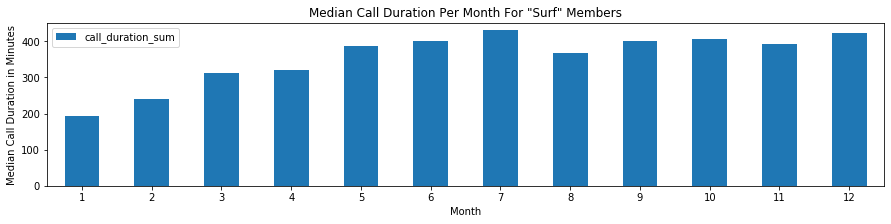

In [11]:
import matplotlib.pyplot as plt
df.query('plan == "surf"').pivot_table(index='month',values='call_duration_sum',aggfunc='median').\
plot(title='Median Call Duration Per Month For "Surf" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median Call Duration in Minutes', fontsize=10); plt.show()

The median call duration for surf members per month appears to range from 230 - 500 minutes. \
This seems to be within the threshold of the package call limits so they are not paying additional fees from it. \
The first quarter of the year has the lowest duration of calls with them being under 400, but it is also important to note \
that these months have relatively low counts of data which makes it prone to skewing.

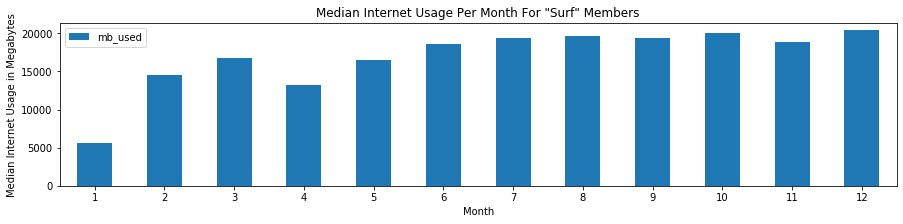

In [12]:
df.query('plan == "surf"').pivot_table(index='month',values='mb_used',aggfunc='median').\
plot(title='Median Internet Usage Per Month For "Surf" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median Internet Usage in Megabytes', fontsize=10) 
plt.show()

The trends seem a bit similar to median call duration, but fluctuates more in the first quarter. \
The first quarter has low amount of internet usage but then ramps up to a consistent 17000 mb usage during the latter half \
of the year. It seems like many months go over the 15000 mb threshold which allows for profit opportunity.

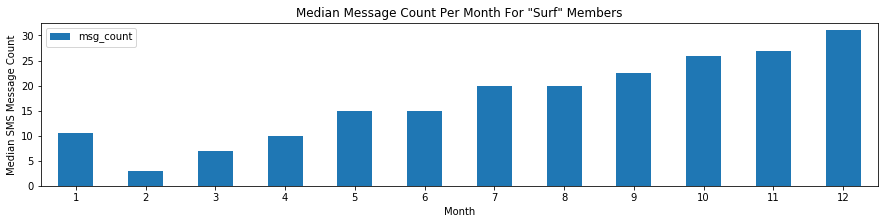

In [13]:
df.query('plan == "surf"').pivot_table(index='month',values='msg_count',aggfunc='median').\
plot(title='Median Message Count Per Month For "Surf" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median SMS Message Count', fontsize=10); plt.show()

There is a drastic change from the early months compared to the late months in terms of message counts. 
Again, there is a postive correlation of median message counts increasing from early to late months. 
None of these months have a median message count that is greater than the 50 count threshold for the plan

In [14]:
df_surf = df.query('plan == "surf"')
descri = pd.merge(df_surf['call_duration_sum'].describe(), df_surf['mb_used'].describe(), 
                  left_index=True, right_index=True, suffixes=('', '2'))
pd.merge(descri, df_surf['msg_count'].describe(), left_index=True, right_index=True, suffixes=('', '2'))

,call_duration_sum,mb_used,msg_count
count,1573.000000,1573.000000,1573.000000
mean,404.762390,18637.252250,31.159568
std,221.664397,8583.964232,33.566717
min,0.000000,0.000000,0.000000
25%,255.470000,13883.130000,3.000000
50%,401.760000,19212.920000,24.000000
75%,543.680000,23602.200000,47.000000
max,1431.220000,74027.410000,266.000000


Above are tables that display the average and standard deviation for call duration, internet usage, and message count. The variation is not displayed within the .describe table, but it is just the square of the standard deviation so respectively, they are: 49135.10, 73684441.93, 1126.72 

###  "Ultimate" members analysis 

In [15]:
df.query('plan == "ultimate"').pivot_table(index='month',values=['call_duration_sum','mb_used','msg_count'],aggfunc='median')

,call_duration_sum,mb_used,msg_count
month,,,
1,221.425,8720.640,12.5
2,398.330,20429.180,15.0
3,236.390,21500.465,12.0
4,283.540,18699.650,17.0
5,385.480,19251.630,19.0
6,377.240,17278.320,21.0
7,403.420,18196.700,28.0
8,388.240,19758.620,36.0
9,410.150,18323.525,31.5


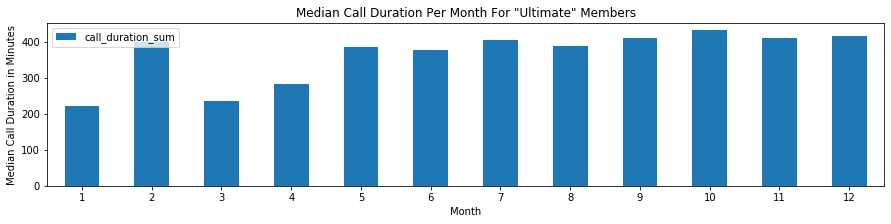

In [16]:
import matplotlib.pyplot as plt
df.query('plan == "ultimate"').pivot_table(index='month',values='call_duration_sum',aggfunc='median').\
plot(title='Median Call Duration Per Month For "Ultimate" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median Call Duration in Minutes', fontsize=10); plt.show()

Similar to surf members, early months such as January, March, and April have lower median call durations compared \
to the latter half of the months. They are all below the 3000 minute threshold so there is no additional profit that \
is being obtained here.

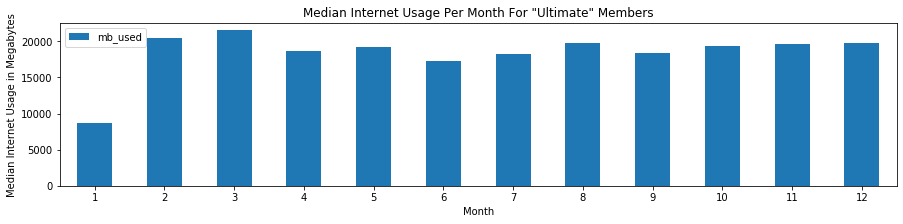

In [17]:
df.query('plan == "ultimate"').pivot_table(index='month',values='mb_used',aggfunc='median').\
plot(title='Median Internet Usage Per Month For "Ultimate" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median Internet Usage in Megabytes', fontsize=10)
plt.show(); 

Other than January, all the months seem to be around the same consistent range. The ultimate package \
has a high 30000 mb capacity and it appears that none of the months have a median that passes that threshold.

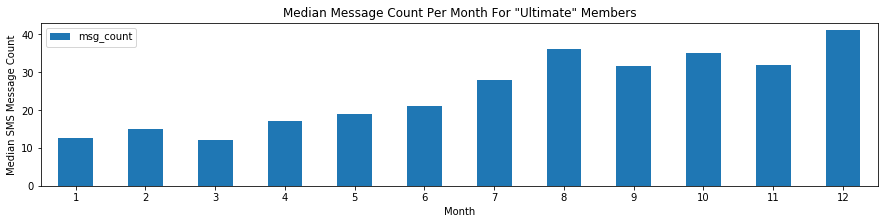

In [18]:
df.query('plan == "ultimate"').pivot_table(index='month',values='msg_count',aggfunc='median').\
plot(title='Median Message Count Per Month For "Ultimate" Members',kind='bar',figsize=(15,3))
plt.xlabel('Month', fontsize=10); plt.xticks(rotation=0); plt.ylabel('Median SMS Message Count', fontsize=10); plt.show()

The former half of the year has a positive correlation of median count of messages rising over time \
and then plateau to a consistent 30+ median message count in the latter half of the year. The package include a high \
1000 message limit which isn't even close to being passed.

In [19]:
df_ultimate = df.query('plan == "ultimate"')
descri = pd.merge(df_ultimate['call_duration_sum'].describe(), df_ultimate['mb_used'].describe(), 
                  left_index=True, right_index=True, suffixes=('', '2'))
pd.merge(descri, df_ultimate['msg_count'].describe(), left_index=True, right_index=True, suffixes=('', '2'))

,call_duration_sum,mb_used,msg_count
count,720.000000,720.000000,720.000000
mean,406.193083,19240.359694,37.551389
std,227.246499,8189.724057,34.767179
min,0.000000,0.000000,0.000000
25%,246.290000,14578.465000,7.000000
50%,398.585000,19273.195000,30.000000
75%,532.227500,23401.652500,61.000000
max,1292.090000,48279.390000,166.000000


Above are tables that display the average and standard deviation for call duration, internet usage, and message count. The variation is not displayed within the .describe table, but it is just the square of the standard deviation so respectively, they are: 51640.97, 67071513.67, 1208.75. These numbers are awfully close to the surf membership variances. 

May 11: call_duration_sum variance changed to match inclusion of 0 minute calls

### Histograms and their distributions

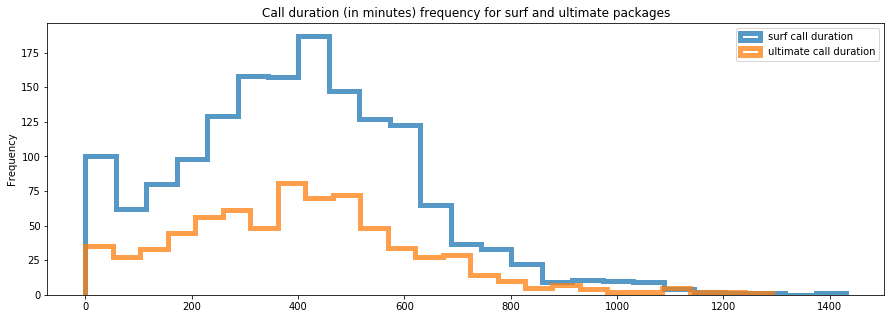

In [20]:
#call duration
axis = df_surf.plot(y='call_duration_sum',kind='hist',histtype='step',
                    figsize=(15,5), linewidth = 5, alpha=.75,label='surf call duration', bins=25)
df_ultimate.plot(y='call_duration_sum',kind='hist',histtype='step',figsize=(15,5), linewidth = 5, 
                 title='Call duration (in minutes) frequency for surf and ultimate packages',
                 alpha=.75,label='ultimate call duration', ax=axis,legend=True,bins=25)

So first thing is first, the count of customers using the surf package is almost double the number of customers
using the ultimate package which explains why the frequency of them are also double in size. The surf call distribution 
appears as a normal bell-curve that is skewed to the right and slightly bimodal as well from the large jump 
in 0 call durations.The jump is 0 minute call durations makes sense because of the data pre-processing that replaced 
all null values to 0 minutes. 

The ultimate call duration distribution would be as if it was a normal distribution with a low degrees of freedom
such as k=4. It represents slight characteristics of a normal distribution, but just is not there yet. It is also skewed
to the right a bit... After looking at jsut the ultimate call duration histogram, I realize the axis of the surf data is 
causing a visual disturbance to what the ultimate data looks like. They both appear as normal distribution curves with a 
closer look

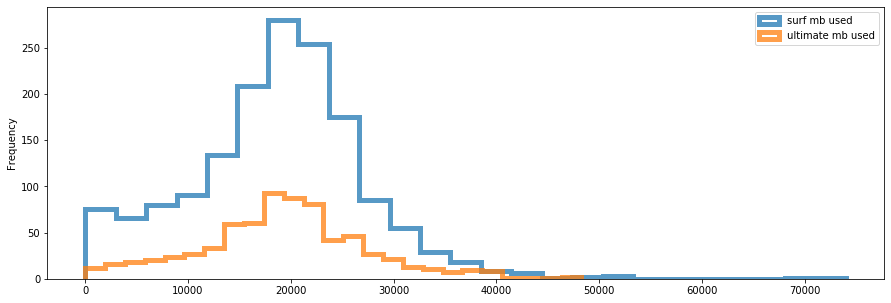

In [21]:
#mb_used
axis = df_surf.plot(y='mb_used',kind='hist',histtype='step',
                    figsize=(15,5), linewidth = 5, alpha=.75,label='surf mb used', bins=25)
df_ultimate.plot(y='mb_used',kind='hist',histtype='step',figsize=(15,5), linewidth = 5, 
                 alpha=.75,label='ultimate mb used', ax=axis,legend=True,bins=25)

The surf package data again appears a mirror image of the ultimate package data, but double in size. 
Again, the surf package internet usage somewhat resembles a normal bell curve and is slightly right skewed. Both have an 
average found at 20000 mb. When viewing only the ultimate data, it also appears to have a normal bell curve.

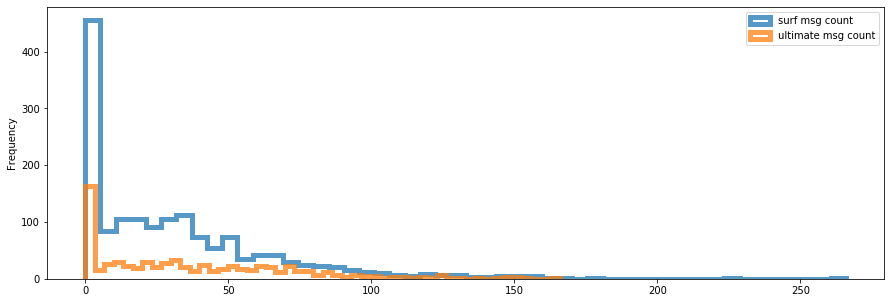

In [22]:
#message count
axis = df_surf.plot(y='msg_count',kind='hist',histtype='step',
                    figsize=(15,5), linewidth = 5, alpha=.75,label='surf msg count', bins=50)
df_ultimate.plot(y='msg_count',kind='hist',histtype='step',figsize=(15,5), linewidth = 5, 
                 alpha=.75,label='ultimate msg count', ax=axis,legend=True,bins=50)

This distribution is odd because it has an extremely high mode located at around the 0 median message count range
and then becomes extremely right skewed. This is applied to both surf and ultimate data.

# Test the hypotheses

### The company earns different amounts from the Ultimate and Surf plans (measured in terms of average monthly revenue)

Comparing the different monthly averages of the two different plans requires a 2 sample t-test. The null hypothesis is claiming H0: mu_sample1 - mu_sample2 = 0 (difference in sample means is equal to zero). While the alternative hypothesis is H1: mu_sample1 - mu_sample2 != 0 (difference in sample means is equal to zero). The samples in this case are the surf and ultimate plans. 

H0: The averages of monthly profit for the Ultimate and Surf plans sample data are equal to each other

H1: The averages of monthly profit for the Ultimate and Surf plans sample data are NOT equal to each other

In [23]:
from scipy import stats as st
surf_profit = df.query('plan == "surf"').drop(df.columns.difference(['monthly_profit']), 1)
ultimate_profit = df.query('plan == "ultimate"').drop(df.columns.difference(['monthly_profit']), 1)
alpha = .05 #using 95% critical value because that's academically standard 
results = st.ttest_ind(surf_profit, ultimate_profit)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("""We can't reject the null hypothesis: There is no reason to believe that the average monthly profits between
              these two plans are different from each other""")

p-value:  [0.51805203]
We can't reject the null hypothesis: There is no reason to believe that the average monthly profits between
              these two plans are different from each other


The p-value tells us that while the average profits for the two package plans are different, there is a ~52% 
probability of randomly getting a difference that amount or greater. 

### Average monthly revenue from users in the NY-NJ area differs from that in other regions.

Comparing the different monthly averages of the two different plans requires a 2 sample t-test. The null hypothesis is claiming H0: mu_sample1 - mu_sample2 = 0 (difference in sample means is equal to zero). While the alternative hypothesis is H1: mu_sample1 - mu_sample2 != 0 (difference in sample means is equal to zero). The samples in this case are NY-NJ .

H0: The average of monthly profit for users in the NY-NJ area and other regions sample data are equal to each other

H1: The average of monthly profit for users in the NY-NJ area and other regions sample data are NOT equal to each other

In [24]:
df_nynj = df.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"').drop(df.columns.difference(['monthly_profit']), 1)
df_other_region = df.query('city not in "New York-Newark-Jersey City, NY-NJ-PA MSA"').\
drop(df.columns.difference(['monthly_profit']), 1)

alpha = .05 #using 95% critical value because that's academically standard 
results = st.ttest_ind(df_nynj, df_other_region)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("""We can't reject the null hypothesis: There is no reason to believe that the average monthly profits between
              the NY-NJ area and other regions are different from each other""")

p-value:  [0.62722099]
We can't reject the null hypothesis: There is no reason to believe that the average monthly profits between
              the NY-NJ area and other regions are different from each other


The p-value tells us that while the average profits for the the NY-NJ area and other regions are different, 
there is a ~63% probability of randomly getting a difference that amount or greater

In [25]:
#Unused Code 
df.drop(df.columns.difference(['call_duration_sum']), 1).describe() #cool way to remove all columns except the selected ones 

,call_duration_sum
count,2293.000000
mean,405.211627
std,223.383523
min,0.000000
25%,249.130000
50%,400.160000
75%,540.450000
max,1431.220000
